### Exercice 4. Transient Flow in 1D

The goal of this exercise is to code and understand a finite difference / finite volume method, solving the problem of one-dimensional Terzaghi flow.

In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# scipy is an extension for numpy, used extensively in scientific computing
import scipy as sp

## One dimensional diffusion

We can imagine a segment of length $2L$ under uniform pore pressure $p_0$. At $t=t_0$, the segment is drained from both ends. Assuming symmetry at $x=L$, we can write the problem for $x \isin [0, L]$ with this one dimensional differential equation:

$$ \frac{\partial p}{\partial t} - c\frac{\partial^2 p}{\partial x^2}=0, $$

also using those boundary conditions:
$$p(x=0, t>0) = 0,$$
$$\frac{\partial p}{\partial x}(x = L, t) = 0$$
and
$$p(x, t=0) = p_0.$$


We will start by defining a very simple one dimensional mesh, which we will use to compute finite differences.

In [2]:
# Mesh definition
L  = 1    # length of the domain
p0 = 1    # initial pressure
c  = 1    # consolidation coefficient
n  = 100  # number of elements

x = np.linspace(0, L, n + 1) # this function of numpy gives you an evenly spaced array
                             # between 0 and L with n + 1 elements (including endpoints)
dx = x[1] - x[0] # dx is the spacing between two entries, i.e., the cell size


print(f'The array of the node coordinates is: {x=}')
print(f'with a cell size of {dx=}')

The array of the node coordinates is: x=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])
with a cell size of dx=np.float64(0.01)


### Finite difference scheme

We can compute this differential equation as a system of equations where we discretize the pressure gradient into a ratio between the pressure difference and the ditance between the measurement points.

We do so by building the matrix $\mathbb{L}$. Take care at the boundaries where you have to adapt the matrix to validate the boundary conditions.

/opt/homebrew/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


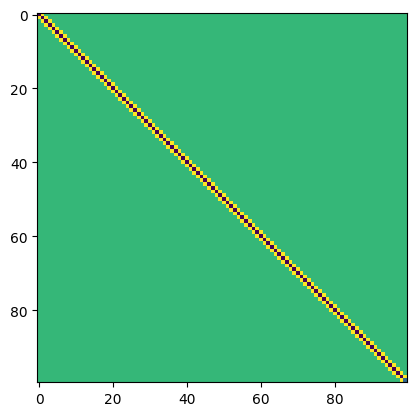

In [3]:
# We first initiate a sparse matrix.
Lmat = sp.sparse.csc_array((n, n))

# We then iterate over all the nodes and assign the corresponding entries.
for i in range(n):
    Lmat[i, i] = -2 # Value at the diagonal

    # Off diagonal values depending on the boundary conditions
    if i == 0:
        Lmat[i, i+1] = 1

    elif i == n - 1:
        Lmat[i, i - 1] = 1
        Lmat[i, i] = -1

    else:
        Lmat[i, i + 1] = 1
        Lmat[i, i - 1] = 1

# Applying the spatial difference
Lmat = Lmat / dx ** 2

# We can now inspect the entries in the matrix
plt.imshow(Lmat.todense())

After the creation of the $\mathbb{L}$ matrix. we are ready to solve the system.

In your parameterchoice recall that $\theta = 0$ gives you a forward Euler (explicit) scheme wherease a $\theta$ of $1$ is equivalent to a backward Euler (implicit) scheme.

In [4]:
# We define the remaining parameters of the problem
theta = 0.8
dt =  30* dx * dx / (2.0 * c) # Recall to take care of the CFL condition

# As we are using a fixed time step dt, we can now pre-define our evaluation times
t = np.arange(0, 1 + dt, dt)
# Lets print the characteristics of our time integration scheme.
print(f'We perform a total of {len(t)=} timesteps.')
print(f'with a timestep of {dt=}')

# We now pre-define the solution vector, where we have one line for every timestep.
heads = np.zeros((len(t), n))
heads[0] = p0

# And also create the identity matrix.
I = sp.sparse.eye(n)

# We observe that the left hand side of our equation is independent on the time and
# current solution, we thus calculate it beforehand.
left = I - theta * c * dt * Lmat
# and prepare it to the solution
leftInv = sp.sparse.linalg.splu(left)

# Finally we iterate over the timesteps and calculate the change in pressure to
# obtain the new head
for i in range(len(t) - 1):
    dp = leftInv.solve(c * dt * Lmat.dot(heads[i]))
    heads[i + 1] = heads[i] + dp

We perform a total of len(t)=668 timesteps.
with a timestep of dt=np.float64(0.0015)


/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_86039/1329254663.py:22: SparseEfficiencyWarning: splu converted its input to CSC format
  leftInv = sp.sparse.linalg.splu(left)


### Comparing with an analytical solution

The analytical solution for the pressure $p(x, t)$ is given by the following equation:

$$ p(x, t) = p_0 \sum_{k=1, 3, ..}^{\infty}\frac{4}{k\pi}\sin\left(\frac{k\pi x^*}{2}\right)\exp(-k^2 \pi^2 t^*),$$

where $x^*=\frac{x}{L}$ and $t^*=\frac{ct}{4L^2}$. We obviously can't compute the terms for values of $k$ all the way to infinity; we must choose a large enough number. As is usually done in python, we want to avoid using for loops and will use vectorization with ``numpy``'s ``meshgrid`` function.

The code below defines a function for you to obtain the analytical solution at a given position $x$, time $t$, and problems of the parameter $L, c,$ and $p_o$.


In [5]:
def analytical_solution(x, t, L, c, p0=1, n=1e3):
    xstar = x/L
    tstar = c * t / (4 * L * L)
    k = np.arange(int(n))[1::2]

    # returns a tuple of shape (nk, nx, nt)
    xx, kk, tt = np.meshgrid(xstar, k, tstar)

    sinus = np.sin(0.5 * kk * np.pi * xx)
    exponent = np.exp(-kk * kk * np.pi * np.pi * tt)
    summed = np.sum(4 / (kk * np.pi) * sinus * exponent, axis=0)

    return p0 * summed

analytical_solution(x, 0, L, 1).shape

(101, 1)

In the following, we compare the analytical solution for our problem parameters to the numerical solution obtained.

Text(0, 0.5, 'pressure (m)')

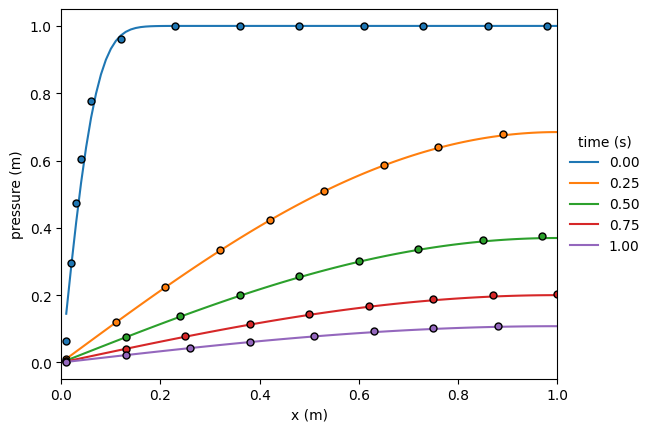

In [6]:
nlines = 5 # Number of time steps we want to plot

# We choose to plot the solution at the beginning end and on three intermediate steps.
for i, ti in enumerate(np.linspace(1, len(t) - 1, nlines).astype(int)):

    # we plot the analytical solution first as a line    
    l, = plt.plot(x[:-1] + dx, analytical_solution(x[:-1] + dx, t[ti], L, c), label=f'{t[ti]:.2f}')

    # we then plot the numerical solution on top as only points
    plt.plot(x[:-1] + dx, heads[ti], c=l.get_color(), ls='none', marker='.', markevery=0.1, ms=10, mec='k')

# Visualization of the solution
plt.legend(title='time (s)', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlim(0, 1)
plt.xlabel('x (m)')
plt.ylabel('pressure (m)')

It is further possible to plot the solution in a time space plot where the color indicates the heads/pressure. 

Text(0.0, 1.0, 'pressure (m)')

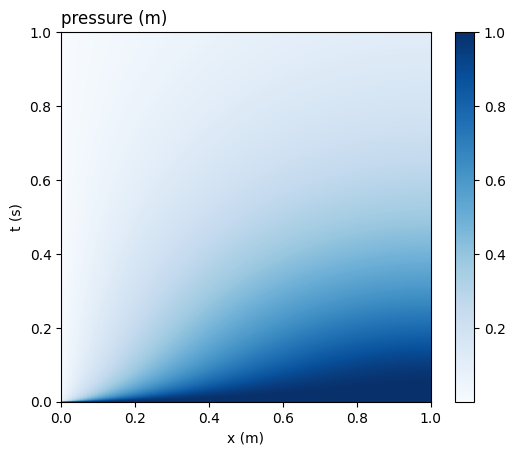

In [7]:

plt.imshow(heads, extent=[x[0], x[-1], t[0], t[-1]], origin='lower', cmap='Blues',)
plt.xlabel('x (m)')
plt.ylabel('t (s)')
cb = plt.colorbar()
plt.title('pressure (m)', loc='left')

Now let us perform an error estimate. For this we first need to obtain the analytical heads at all positions where we have the numerical solution. We then calculate the error in percent.

In [8]:
# We get the analytical heads
anal_heads = analytical_solution(x[:-1] + dx, t, L, c).T

# and calculate the error
error = 100 * (anal_heads - heads)/anal_heads

Text(0.0, 1.0, 'relative error (%)')

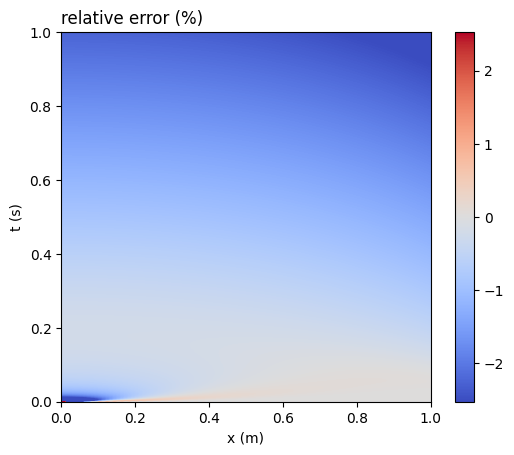

In [9]:
# The following line is only to obtain the limits of the colorbar.
vmax = np.quantile(np.abs(error), 0.99)

# We visualize the error in the same way as we had visualized the solution on the domain.
plt.imshow(error, extent=[x[0], x[-1], t[0], t[-1]], origin='lower', cmap='coolwarm', vmin=-vmax, vmax=vmax)
plt.xlabel('x (m)')
plt.ylabel('t (s)')
cb = plt.colorbar()
plt.title('relative error (%)', loc='left')